<a href="https://colab.research.google.com/github/techgoddess1/emotion_detection/blob/main/Copy_of_emotion_det_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries for data preprocessing
import pandas as pd
import numpy as np

# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
import tensorflow as tf
import cv2
from PIL import Image

# Transfer learning Libraries
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0,MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

import os
import random

In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.set_visible_devices(physical_devices[0], 'GPU')

### Reading in the Dataset

In [ ]:
# # Unzippping the dataset
# import zipfile
# with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
#      zip_ref.extractall(r'''\\adir.hull.ac.uk\home\700\700970\Downloads\emotion_detection''')

In [ ]:
# #getting the train directory
# train_dir = './train'

# #getting the test directory
# test_dir =  './test'

In [ ]:
# Upload the zip file to Colab
from google.colab import files
uploaded = files.upload()

# Extract the contents of the zip file
import zipfile
with zipfile.ZipFile('EmotionDetection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')
    
# Define the directory paths
train_dir = '/content/data/train'
validation_dir = '/content/data/validation'
test_dir = '/content/data/test'

### Preprocessing the dataset

In [ ]:
# creating the datagenerator that will read in the images stored as train images
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
train_data = image_dataset_from_directory(directory=train_dir,
                                              seed=72,
                                              shuffle=True,
                                              validation_split = 0.20,
                                              batch_size = 70,
                                              #color_mode = 'grayscale',
                                              label_mode='categorical',
                                              image_size=(124,124),
                                              subset='training') 


# Flow validation images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
val_data = image_dataset_from_directory(directory=train_dir,
                                            shuffle=True,
                                            batch_size = 70,
                                            validation_split = 0.05,
                                            seed= 72,
                                            #color_mode = 'grayscale',
                                            label_mode='categorical',
                                            image_size=(124,124),
                                            subset='validation')
# Flow test images in batches of 16 using datagen generator and resizing from 224 by 224 to 32 by 32
test_data = image_dataset_from_directory(directory=test_dir,
                                            shuffle=True,
                                            batch_size = 70,
                                            seed= 72,
                                            #color_mode = 'grayscale',
                                            label_mode='categorical',
                                            image_size=(124,124))


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 1435 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
# Check dimension of the train generator
next(iter(train_data))[0].shape

TensorShape([70, 124, 124, 3])

In [ ]:
# Check dimension of the validation generator
next(iter(val_data))[0].shape

TensorShape([70, 124, 124, 3])

In [ ]:
class_names = train_data.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


### Configuring the dataset for perfomance

In [ ]:
# # Using buffers prefetching to load images from disk 
AUTOTUNE = tf.data.AUTOTUNE
train_data= train_data.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

### Using Data Augumentation

In [ ]:
# tranforming the dataset by randomly flipping ,rotating the dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

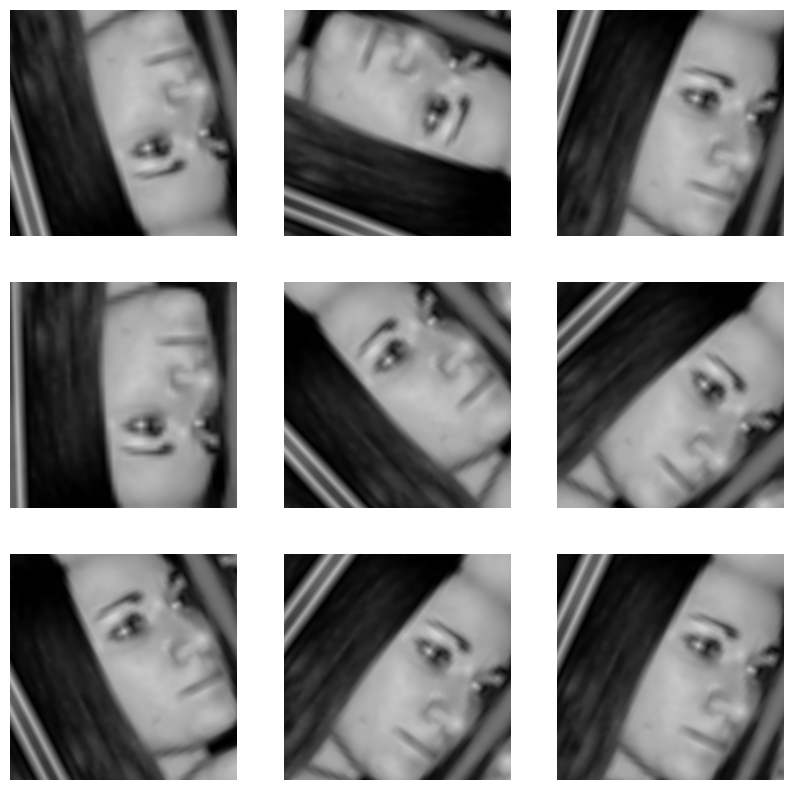

In [ ]:
# Applying the augmentation to the first image repeatedly
for image,_ in train_data.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i +1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

### Building the custom built CNN model

In [ ]:
# Set the image dimensions
IMG_WIDTH = 124
IMG_HEIGHT = 124
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
epochs = 110
batch_size = 32

In [ ]:
# Instantiating the custom built model
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))  # add dropout here

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.002)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l1(0.002)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) 

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.25)) 

model.add(Dense(512,activation = 'relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
# Compiling the model with categorical crossentropy and Adam optimizer
model.compile(
     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
     loss='categorical_crossentropy',
     metrics=['accuracy'])

In [ ]:
# Checking the summary of the built model
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 124, 124, 32)      896       
                                                                 
 conv2d_41 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 41, 41, 64)       0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 41, 41, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 41, 41, 128)       204928    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                 

In [ ]:
from keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [ ]:
# Training the model 
history = model.fit(train_data,
                    epochs = epochs,
                    validation_data = val_data,
                    batch_size = batch_size,
                    verbose = 2)

Epoch 1/110
329/329 - 10s - loss: 63.6797 - accuracy: 0.1757 - val_loss: 60.5888 - val_accuracy: 0.2202 - 10s/epoch - 31ms/step
Epoch 2/110
329/329 - 7s - loss: 59.2184 - accuracy: 0.2010 - val_loss: 57.7340 - val_accuracy: 0.2376 - 7s/epoch - 22ms/step
Epoch 3/110
329/329 - 7s - loss: 56.0727 - accuracy: 0.2250 - val_loss: 54.3848 - val_accuracy: 0.2293 - 7s/epoch - 22ms/step
Epoch 4/110
329/329 - 7s - loss: 52.5489 - accuracy: 0.2348 - val_loss: 50.7169 - val_accuracy: 0.2432 - 7s/epoch - 22ms/step
Epoch 5/110
329/329 - 7s - loss: 48.7560 - accuracy: 0.2449 - val_loss: 46.8239 - val_accuracy: 0.2397 - 7s/epoch - 22ms/step
Epoch 6/110
329/329 - 7s - loss: 44.7922 - accuracy: 0.2435 - val_loss: 42.8017 - val_accuracy: 0.2397 - 7s/epoch - 22ms/step
Epoch 7/110
329/329 - 7s - loss: 40.7348 - accuracy: 0.2477 - val_loss: 38.7438 - val_accuracy: 0.2439 - 7s/epoch - 22ms/step
Epoch 8/110
329/329 - 7s - loss: 36.6869 - accuracy: 0.2487 - val_loss: 34.7275 - val_accuracy: 0.2411 - 7s/epoch - 

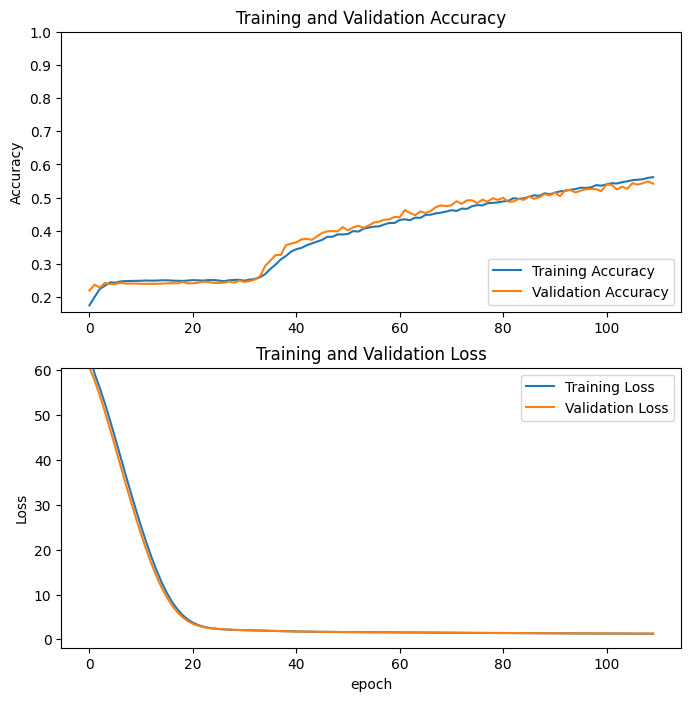

In [ ]:
# Plotting the learning curve
train_acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()), max(val_loss)])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

#### Saving the custom model

In [ ]:
model.save('custom_emotion_model.h5')

In [ ]:
#model.save('custom_emotion_model2.h5')

In [ ]:
#model.save('custom_emotion_model3.h5')

##### Model Evaluation 

In [ ]:
print('Testing Accuracy',model.evaluate(test_data))

103/103 [==============================] - 1s 12ms/step - loss: 1.3280 - accuracy: 0.5364
Testing Accuracy [1.3279633522033691, 0.5363610982894897]


### Using Transfer Learning Algorithms 

#### Using Mobilenet

In [ ]:
# Set the image dimensions
img_size = (124,124)
batch_size = 80
IMG_WIDTH = 124
IMG_HEIGHT = 124
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)

In [ ]:
# Preprocess the image using mobilenet preprocess_input function
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = img_size + (3,)
mobilenet_base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_data))
feature_batch = mobilenet_base_model(image_batch)
print(feature_batch.shape)

(70, 4, 4, 1280)


In [ ]:
### Freeze the convolutional Layer
mobilenet_base_model.trainable = False

In [ ]:
#Reducing the spatial dimension of the input feature and applying it to the feature batch 
max_layer = tf.keras.layers.MaxPooling2D()
feature_batch_max = max_layer(feature_batch)
print(feature_batch_max.shape)

(70, 2, 2, 1280)


In [ ]:
# Applying a dense layer to convert the features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(7)
# prediction_batch = prediction_layer(feature_batch_max)
# print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(124, 124, 3))

# Data augmentation layer
x = data_augmentation(inputs)

# Preprocessing layer
x = preprocess_input(x)

# Base model layer
x = mobilenet_base_model(x, training=False)

# Global average pooling layer
x = max_layer(x)

# Flatten layer
x = tf.keras.layers.Flatten()(x)

# Additional hidden layers
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1280, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# Output layer
outputs = prediction_layer(x)

# Define the model
mobilenet_model = tf.keras.Model(inputs, outputs)

In [ ]:
# Taking a look at the base model architecture
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 124, 124, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 124, 124, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# Compiling the model
learning_rate = 0.00002
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Checking the trainable variable objects
len(mobilenet_model.trainable_variables)

20

In [ ]:
mobilenet_history = mobilenet_model.fit(train_data,
                                        epochs=80,
                                        validation_data=val_data)

Epoch 1/80
329/329 [==============================] - 13s 19ms/step - loss: 6.2465 - accuracy: 0.1372 - val_loss: 3.1464 - val_accuracy: 0.2376
Epoch 2/80
329/329 [==============================] - 5s 16ms/step - loss: 7.9687 - accuracy: 0.2076 - val_loss: 6.2970 - val_accuracy: 0.2404
Epoch 3/80
329/329 [==============================] - 5s 16ms/step - loss: 7.5795 - accuracy: 0.2329 - val_loss: 3.9092 - val_accuracy: 0.2404
Epoch 4/80
329/329 [==============================] - 5s 16ms/step - loss: 7.7475 - accuracy: 0.2116 - val_loss: 5.4185 - val_accuracy: 0.2404
Epoch 5/80
329/329 [==============================] - 5s 16ms/step - loss: 5.3485 - accuracy: 0.2502 - val_loss: 4.8501 - val_accuracy: 0.2404
Epoch 6/80
329/329 [==============================] - 5s 16ms/step - loss: 6.4278 - accuracy: 0.2505 - val_loss: 12.0521 - val_accuracy: 0.2404
Epoch 7/80
329/329 [==============================] - 5s 16ms/step - loss: 6.7211 - accuracy: 0.2506 - val_loss: 4.7505 - val_accuracy: 0.24

##### Learning Curves

In [ ]:
# Plotting the learning curve
train_acc2 = mobilenet_history.history['accuracy']
val_acc2 =mobilenet_history.history['val_accuracy']

train_loss2 = mobilenet_history.history['loss']
val_loss2 = mobilenet_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([min(plt.ylim()), max(val_loss)])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

##### Fine Tuning

In [ ]:
# Unfreeze the top layers of the model
mobilenet_base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
# Compile the model
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/100),
              metrics=['accuracy'])

In [ ]:
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 124, 124, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 124, 124, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(mobilenet_model.trainable_variables)

146

##### Train the model

In [ ]:
initial_epochs = 30

loss2, accuracy2 = mobilenet_model.evaluate(val_data)

21/21 [==============================] - 2s 11ms/step - loss: 6.3237 - accuracy: 0.1944


In [ ]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

mobilenet_history_fine = mobilenet_model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=mobilenet_history.epoch[-1],
                          validation_data=val_data)

Epoch 80/120
329/329 [==============================] - 33s 34ms/step - loss: 7.0653 - accuracy: 0.1854 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 81/120
329/329 [==============================] - 11s 32ms/step - loss: 7.1740 - accuracy: 0.1866 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 82/120
329/329 [==============================] - 11s 32ms/step - loss: 7.1447 - accuracy: 0.1861 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 83/120
329/329 [==============================] - 11s 32ms/step - loss: 7.2069 - accuracy: 0.1883 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 84/120
329/329 [==============================] - 11s 32ms/step - loss: 7.0714 - accuracy: 0.1870 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 85/120
329/329 [==============================] - 11s 32ms/step - loss: 7.1372 - accuracy: 0.1852 - val_loss: 6.3237 - val_accuracy: 0.1944
Epoch 86/120
329/329 [==============================] - 11s 32ms/step - loss: 7.2782 - accuracy: 0.1848 - val_loss: 6.3237 -

### Using Alexnet

In [ ]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))
        '''
        self.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6), 
                     metrics=['accuracy',tf.keras.losses.MeanSquaredError()])
        
        self.compile(optimizer= tf.keras.optimizers.Adam( 0.0005),
                    loss='categorical_crossentropy',
                    metrics=['acc'])
        metrics=['accuracy']
        model.compile(loss=positive_mse,
              optimizer=Adam(lr=LEARNING_RATE, decay=DECAY),
              metrics=[tf.keras.losses.MeanSquaredError()])
              
              model.compile(optimizer='adam', loss="categorical_crossentropy", 
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
              tf.keras.metrics.SensitivityAtSpecificity(0.5), 
              tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.AUC(curve='ROC')])

            '''

In [ ]:
from tensorflow.keras.optimizers import Adam, Adamax
model = AlexNet((224, 224, 3), outputs)
model.compile(tf.keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(0)

TypeError: ignored